## OGR Simple Features Library
OGR Simple Features Library (part of the GDAL), offers set of tools for dealing with vector data. Although GDAL and OGR are highly intergrated, they can generally be separated as: 
- OGR for vector data
- GDAL for raster data

OGR has the following major parts: 
- OGR Commands
- ogrmerge - an instant python script for merging multiple vector data files
- OGR library itself

## OGR Commands
OGR offers a series of batch commands that can be used to describe and convert existing geospatila vector data. e.g
- ogrinfo - used for doing all sort of reporting on vector data -eg listing supported formats, available layers, summary etc
- ogr2ogr - for doing vector data translations between different formats.
- ogrtindex and ogr2vrt 

Both ogrinfor and ogr2ogr may be combined with sql queries to perform more complex spatial tasks. 

## OGR MERGE
Along with the installation of gdal, comes a set of scripts that can be used for specialized geospatial tasks. In macos installations these scripts are located here: /opt/anaconda3/pkgs/gdal-3.6.2-py312h5ed0132_5/bin 

In [18]:
%run "/opt/anaconda3/pkgs/gdal-3.6.2-py312h5ed0132_5/bin/ogrmerge.py" -f GPKG -o data/merged.gpkg "data/NE/10m_cultural//*.shp" 

Warning 1: A geometry of type MULTILINESTRING is inserted into layer ne_10m_roads of geometry type LINESTRING, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type MULTILINESTRING is inserted into layer ne_10m_parks_and_protected_lands_line of geometry type LINESTRING, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type MULTIPOLYGON is inserted into layer ne_10m_admin_2_counties_lakes of geometry type POLYGON, which i

## OGR LIBRARY and Python Bindings
Using OGR Library and the Python bindings, we are able to work with vector data in python, allowing us to create points, lines and polygons and perform geospatial operations on these elements. 

The OGR library consist of two main modules - ogr and osr, both are part of the osgeo module. The ogr deals with vector geometry while the osr deals with the projections. 

OGR offers the following seven classes: 
- Geometry
- Spatial Reference
- Feature
- Feature Class Definition
- Layer
- Dataset
- Drivers

## Creating Polygon with OGR 
OGR lets you write vector geometries such as points, lines, mulitipoints, multilinestrings, multipolygons and geometry collections. 
You can give these geometry values in coordinates or meters if you plan to project them later. All geometries you create follow the same 
procedure, separate points are defined and then strung together as lines or polygons. You define separate entities in numbers, encode them 
in well-known binary (WKB), and the final polygon is translated to well-known text (WKT).

In [24]:
from osgeo import ogr
r = ogr.Geometry(ogr.wkbLinearRing)
r.AddPoint(1,1)
r.AddPoint(5,1)
r.AddPoint(5,5)
r.AddPoint(1,5)
r.AddPoint(1,1)
poly = ogr.Geometry(ogr.wkbPolygon)
poly.AddGeometry(r)
print(poly.ExportToWkt())


POLYGON ((1 1 0,5 1 0,5 5 0,1 5 0,1 1 0))


## Creating polygon geometry from GeoJSON


In [35]:
from osgeo import ogr
geojson = """ {"type":"Polygon","coordinates":[[[1,1],[5,1],[5,5],[1,5],[1,1]]]}"""

In [37]:
polygon = ogr.CreateGeometryFromJson(geojson)
print(polygon)

POLYGON ((1 1,5 1,5 5,1 5,1 1))


## Basic Geometric Operations 

In [48]:
# Get Polygon Area
print("The area of the polygon is {}".format(polygon.Area()))

The area of the polygon is 16.0


In [50]:
# Get Polygon Area
print("The centroid of the polygon is {}".format(polygon.Centroid()))

The centroid of the polygon is POINT (3 3)


In [52]:
# Get the boundary : 
b = polygon.GetBoundary()
print(b)

LINESTRING (1 1,5 1,5 5,1 5,1 1)


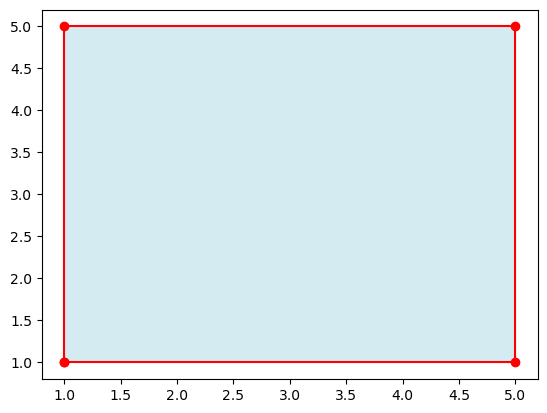

In [70]:
x = []
y = []
for i in range(b.GetPointCount()):
    lon, lat, _ = b.GetPoint(i)
    x.append(lon)
    y.append(lat)

# Step 3: Plot the polygon boundary using matplotlib
plt.plot(x, y, marker='o', color='r')  # Plot the boundary with points (marker='o')
plt.fill(x, y, color='lightblue', alpha=0.5)  # Fill

ConvexHull will do the same thing in this case since the polygon is a square 

In [73]:
ch = polygon.ConvexHull()
print(ch)

POLYGON ((1 1,1 5,5 5,5 1,1 1))


## Writing polygon data to a newly created shapefile
NOTE: Our current polygon only exists in memory. We want to create a new shapefile and the polygon geometry to this shapefile.

In [91]:
import osgeo.ogr, osgeo.osr
#Set the spatial reference

spatialReference = osgeo.osr.SpatialReference()
spatialReference.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# create a new shapefile 
driver = osgeo.ogr.GetDriverByName('ESRI Shapefile')
shapeData = driver.CreateDataSource('data/sample_polygon/my_polygon.shp')

# create the layer 
layer = shapeData.CreateLayer('polygon_layer',spatialReference,osgeo.ogr.wkbPolygon)
layerDefinition = layer.GetLayerDefn()

# geometry is put inside the feature
featureIndex = 0
feature = osgeo.ogr.Feature(layerDefinition)
feature.SetGeometry(polygon)
feature.SetFID(featureIndex)

#5 feature is put into the layer 
layer.CreateFeature(feature)

0

We can use ogr to see if the file has been created successfuly

In [94]:
!ogrinfo data/sample_polygon/my_polygon.shp 

INFO: Open of `data/sample_polygon/my_polygon.shp'
      using driver `ESRI Shapefile' successful.
1: my_polygon (Polygon)


## Using a spatial filter to select features

In [120]:
#import the modules 

from osgeo import ogr
import os

#reference the shapefile and specify driver type
cwd = os.getcwd()
shapefile = os.path.join(cwd,"data/NE/10m_cultural/ne_10m_populated_places.shp")
driver = ogr.GetDriverByName("ESRI Shapefile")

# open the data source with driver, zero means open in read only mode 
dataSource = driver.Open(shapefile,0)
#use the GetLayer() function for referencing the layer that holds the data

layer = dataSource.GetLayer()
#pass in the coordinates for the dataframes to the SetSpatialFilterRect() function, this filter creates a rectagular extent and 
#select features inside the extent 
layer.SetSpatialFilterRect(-102,26,-94,36) 
for feature in layer: 
    #select only the cities inside the USA
    if feature.GetField("ADM0NAME") != "United States of America":
        continue; 
    else: 
        print(feature.GetField("NAME"))

Ardmore
McAlester
Bryan
San Marcos
Longview
McAllen
Harlingen
Alice
New Braunfels
Cleburne
Brownwood
Big Spring
Vernon
Childress
Texas City
Pasadena
Baytown
Arlington
Texarkana
Fort Smith
Lawton
Norman
Muskogee
Shawnee
Conroe
Nacogdoches
Eagle Pass
Edinburg
Kingsville
Huntsville
Killeen
Lufkin
Del Rio
San Angelo
Sherman
Beaumont
Bay City
Port Lavaca
Falfurrias
Beeville
Dumas
Denton
Temple
Galveston
Freeport
Victoria
Wichita Falls
Waco
Lubbock
Abilene
Tyler
Ft.  Worth
Corpus Christi
Austin
Amarillo
Laredo
Oklahoma City
San Antonio
Dallas
Houston


## Shapely and Fiona 
Shapely depends on other libraries for reading and writing file. Fiona can be used to complement shapely.
- The Shapely library is used for creating and manipulating 2D vector data without the need for a spatial database.
- Also the shapely library does not deal with projections and data formats, it only deal with geometry.
- Its biggest strength is that uses easily-readable syntax to create a variety of geometries that can be used for geometric operations. 

### Shapely methods for geospatial analysis
- Topological relationships are implemented as methods on geometric objects (e.g contains, touches and more)
- Shapely also provides analysis methods that return new geometric objects (intersections,unions and more)

## FIONA's data model
Although Fiona is OGR's Python wrapper, Fiona uses a data model that differes from OGR. While OGR uses data sources,layers and features, Fiona uses the term records for accessing geographic features stored in vector data. When reading a shapefile with Fiona, you reference a record through one of its keys, using python dictionary object. A record has ID,geometry, and property key.

## Examples: 

## Creating geometries with Shapely
Just like OGR, you can use Shapely to create geometries. Jupyter Notebook will plot the geometries after you have create them. 

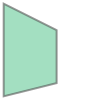

In [132]:
from shapely.geometry import Polygon
p1 = Polygon(((1, 2), (5, 3), (5, 7), (1, 9), (1, 2)))
p2 = Polygon(((6,6), (7,6), (10,4), (11,8), (6,6)))
p1

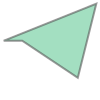

In [134]:
p2

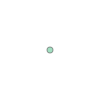

In [136]:
# Point takes tuples as well as positional coordinates values 
from shapely.geometry import Point
point = Point(2.0,2.0)
q = Point((2.0,2.0))
q

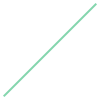

In [138]:
#Line Geometry 
from shapely.geometry import LineString
line = LineString([(0,0),(10,10)])
line

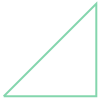

In [142]:
# Linear rings 
from shapely.geometry import LinearRing
ring = LinearRing([(0,0),(3,3),(3,0)])
ring

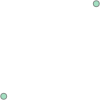

In [144]:
#collection of points 
from shapely.geometry import MultiPoint
points = MultiPoint([(0.0,0.0),(3.0,3.0)])
points

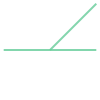

In [148]:
# collection of lines 
from shapely.geometry import MultiLineString
coords = [((0, 0), (1, 1)), ((-1, 0), (1, 0))]
lines = MultiLineString(coords)
lines

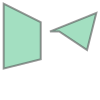

In [150]:
# collection of polygons 
from shapely.geometry import MultiPolygon
polygons = MultiPolygon([p1,p2])
polygons

## Applying geometrical methods with Shapely

In [153]:
print(p1.area)       
print(p1.bounds)       
print(p1.length)       
print(p1.geom_type)

22.0
(1.0, 2.0, 5.0, 9.0)
19.59524158061724
Polygon


## Reading JSON geometries with shapely 
Although Shapely does not read or write data files, you can access geometries from outside of the library, for instance, by feeding it vector data written in json.

In [157]:
import json 
from shapely.geometry import mapping, shape
p = shape(json.loads('{"type":"Polygon", "coordinates":[[[1,1], [1,3 ], [3,3]]]}'))
print(json.dumps(mapping(p)))
p.area

{"type": "Polygon", "coordinates": [[[1.0, 1.0], [1.0, 3.0], [3.0, 3.0], [1.0, 1.0]]]}


2.0

## Reading Data with Fiona 

In [163]:
import fiona

c = fiona.open("data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp")
rec = next(iter(c))
rec.keys()

ERROR 1: PROJ: internal_proj_identify: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


KeysView(fiona.Feature(geometry=fiona.Geometry(coordinates=[[(-89.95765601272012, 47.286907253603175), ...]], type='Polygon'), id='0', properties=fiona.Properties(featurecla='Admin-1 scale rank', scalerank=2, adm1_code='USA-3514', diss_me=3514, iso_3166_2='US-MN', wikipedia='http://en.wikipedia.org/wiki/Minnesota', iso_a2='US', adm0_sr=1, name='Minnesota', name_alt='MN|Minn.', name_local=None, type='State', type_en='State', code_local='US27', code_hasc='US.MN', note=None, hasc_maybe=None, region='Midwest', region_cod=None, provnum_ne=0, gadm_level=1, check_me=20, datarank=1, abbrev='Minn.', postal='MN', area_sqkm=0, sameascity=-99, labelrank=0, name_len=9, mapcolor9=1, mapcolor13=1, fips='US27', fips_alt=None, woe_id=2347582, woe_label='Minnesota, US, United States', woe_name='Minnesota', latitude=46.0592, longitude=-93.364, sov_a3='US1', adm0_a3='USA', adm0_label=2, admin='United States of America', geonunit='United States of America', gu_a3='USA', gn_id=5037779, gn_name='Minnesota', 

In [179]:
import pprint

pprint.pprint(rec['id'])
pprint.pprint(rec['properties'])
pprint.pprint(rec['geometry'])




fiona.Geometry(coordinates=[[(-89.95765601272012, 47.286907253603175), ...]], type='Polygon')


In [185]:
print(len(c)) # prints total amount of features 
print(c.driver) # print driver name 
print(c.crs) # prints coordinate reference system of data

51
ESRI Shapefile
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


ERROR 1: PROJ: internal_proj_identify: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


## Accessing vector geometry in shapefiles using Shapely and Fiona 
Using Fiona we can open a shapefile and access attribute data, such as geometries. E.g Our Natural Earth Dataset contains a shapefile with all of the states in the US with vector geometries. 

In [206]:
import pprint, fiona

with fiona.open("data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp") as src:
    pprint.pprint(src[0])

fiona.Feature(geometry=fiona.Geometry(coordinates=[[(-89.95765601272012, 47.286907253603175), ...]], type='Polygon'), id='0', properties=fiona.Properties(featurecla='Admin-1 scale rank', scalerank=2, adm1_code='USA-3514', diss_me=3514, iso_3166_2='US-MN', wikipedia='http://en.wikipedia.org/wiki/Minnesota', iso_a2='US', adm0_sr=1, name='Minnesota', name_alt='MN|Minn.', name_local=None, type='State', type_en='State', code_local='US27', code_hasc='US.MN', note=None, hasc_maybe=None, region='Midwest', region_cod=None, provnum_ne=0, gadm_level=1, check_me=20, datarank=1, abbrev='Minn.', postal='MN', area_sqkm=0, sameascity=-99, labelrank=0, name_len=9, mapcolor9=1, mapcolor13=1, fips='US27', fips_alt=None, woe_id=2347582, woe_label='Minnesota, US, United States', woe_name='Minnesota', latitude=46.0592, longitude=-93.364, sov_a3='US1', adm0_a3='USA', adm0_label=2, admin='United States of America', geonunit='United States of America', gu_a3='USA', gn_id=5037779, gn_name='Minnesota', gns_id=-1

We can use the shape method and pass in all of the coordinates from Minnesota

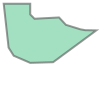

In [208]:
from shapely.geometry import shape

minnesota = {
    'type': 'Polygon',
    'coordinates': [[
        (-97.239209, 49.384358),  # Northwest corner (Minnesota-Manitoba border)
        (-95.152984, 49.384358),  # Northern border along Canada
        (-95.152984, 48.540969),  # Northern border along Lake of the Woods
        (-94.81758, 48.202054),   # Northern border down to Rainy Lake
        (-92.888114, 48.302917),  # Northern edge near Rainy River
        (-92.348614, 47.722114),  # Northern central part near Boundary Waters
        (-91.202651, 47.368601),  # Northeast edge along Lake Superior
        (-90.83029, 47.30284),    # Eastern edge near Lake Superior
        (-89.957656, 47.286907),  # Eastern tip along Lake Superior
        (-93.356646, 44.783156),  # Southern central part near Minneapolis
        (-95.153404, 44.73168),   # Western central part
        (-96.453138, 45.293466),  # Southwestern corner
        (-96.85623, 45.932139),   # Northwestern corner
        (-97.239209, 49.384358)   # Closing the polygon back at Northwest
    ]]
}


geom = shape(minnesota)
geom

# Geospatial Analysis with - GeoPandas 

## Selecting and Plotting geometry data with GeoPandas and Matplotlib

In [215]:
import geopandas as gpd 
%matplotlib inline 
df = gpd.read_file("data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp")
df.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.0595 49.00..."
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."
3,Admin-1 scale rank,2,USA-3517,3517,US-HI,http://en.wikipedia.org/wiki/Hawaii,US,8,Hawaii,HI|Hawaii,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080..."
4,Admin-1 scale rank,2,USA-3518,3518,US-ID,http://en.wikipedia.org/wiki/Idaho,US,1,Idaho,ID|Idaho,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -115.9678 47.95..."


In [217]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [221]:
df.shape

(51, 122)

In [223]:
df.columns

Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt',
       ...
       'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT', 'FCLASS_NL',
       'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'FCLASS_TLC', 'geometry'],
      dtype='object', length=122)

Accessing separate rows of our geo data frome using pandas .loc and .iloc

In [226]:
df.loc[0]

featurecla                                   Admin-1 scale rank
scalerank                                                     2
adm1_code                                              USA-3514
diss_me                                                    3514
iso_3166_2                                                US-MN
                                    ...                        
FCLASS_SE                                                  None
FCLASS_BD                                                  None
FCLASS_UA                                                  None
FCLASS_TLC                                                 None
geometry      POLYGON ((-89.95765601272012 47.28690725360317...
Name: 0, Length: 122, dtype: object

In [228]:
df['name']

0                Minnesota
1                  Montana
2             North Dakota
3                   Hawaii
4                    Idaho
5               Washington
6                  Arizona
7               California
8                 Colorado
9                   Nevada
10              New Mexico
11                  Oregon
12                    Utah
13                 Wyoming
14                Arkansas
15                    Iowa
16                  Kansas
17                Missouri
18                Nebraska
19                Oklahoma
20            South Dakota
21               Louisiana
22                   Texas
23             Connecticut
24           Massachusetts
25           New Hampshire
26            Rhode Island
27                 Vermont
28                 Alabama
29                 Florida
30                 Georgia
31             Mississippi
32          South Carolina
33                Illinois
34                 Indiana
35                Kentucky
36          North Carolina
3

In [238]:
illinois = df.loc[df['name'] == "Illinois"]
illinois

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
33,Admin-1 scale rank,2,USA-3546,3546,US-IL,http://en.wikipedia.org/wiki/Illinois,US,1,Illinois,IL|Ill.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-91.43033 40.3686, -91.41023 40.5511..."


<Axes: >

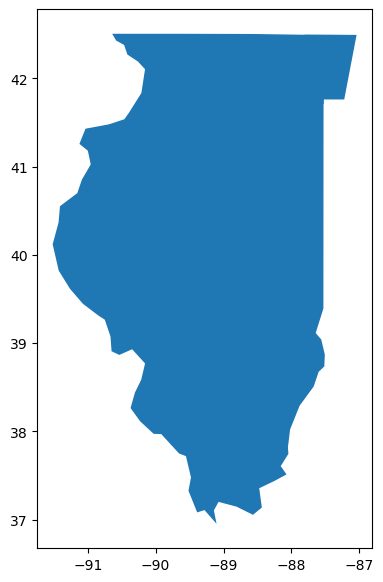

In [240]:
illinois.plot(figsize=(7,7))

You can plot multiple items using the .iloc function and pass it a list of row numbers;

<Axes: >

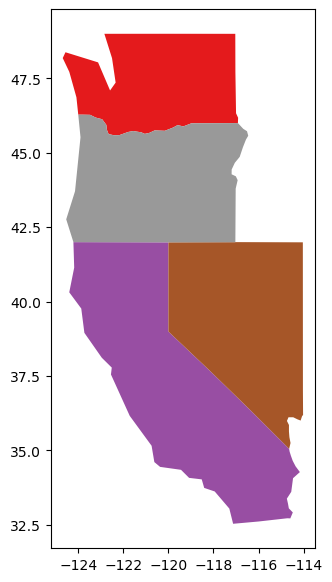

In [260]:
multipl = df.iloc[[5,7,9,11]]
multipl.plot(cmap="Set1", figsize=(7,7))

The same results can be obtained using the .cx method on the GeoDataFrame, passing in values for a bounding box

<Axes: >

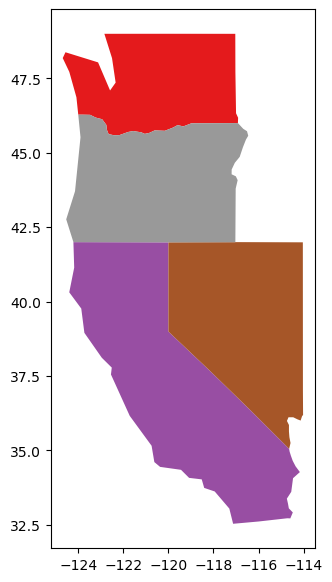

In [269]:
exp = df.cx[-124:-118, 30:50]
exp.plot(cmap="Set1", figsize=(7, 7))

## Mapping wildfire data with GeoPandas

In [272]:
import geopandas as gpd 
states = gpd.read_file("data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp")
states.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.0595 49.00..."
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."
3,Admin-1 scale rank,2,USA-3517,3517,US-HI,http://en.wikipedia.org/wiki/Hawaii,US,8,Hawaii,HI|Hawaii,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080..."
4,Admin-1 scale rank,2,USA-3518,3518,US-ID,http://en.wikipedia.org/wiki/Idaho,US,1,Idaho,ID|Idaho,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -115.9678 47.95..."


<Axes: >

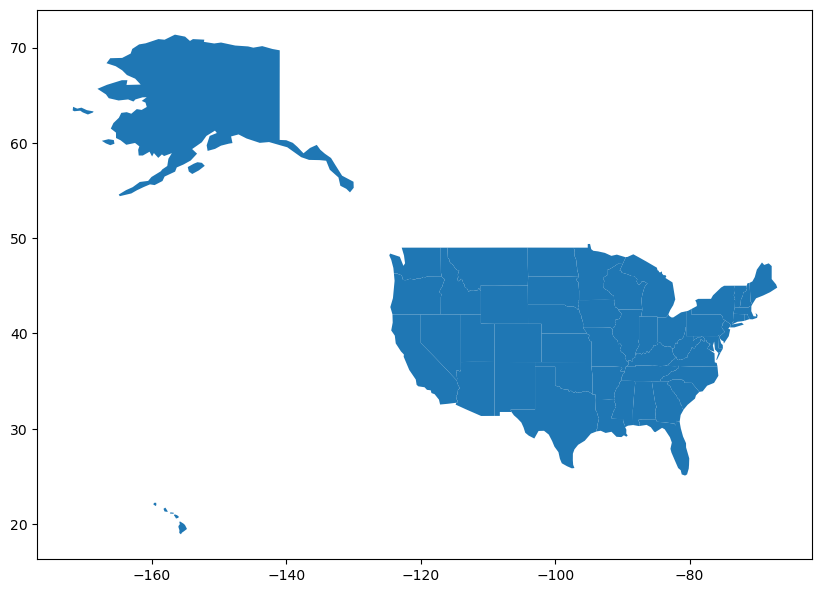

In [274]:
states.plot(figsize=(10,10))

The same procedure is repeated for our wildfire data.

In [279]:
fires = gpd.read_file("data/mtbs_fod_pts_data/mtbs_FODpoints_DD.shp")
fires.head()

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,ORIG_FID,geometry
0,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,-157.421,...,27,-9999,-970,-150,130,334,585,None,0,POINT (-157.42071 62.60301)
1,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,-156.645,...,3,-9999,-970,-150,70,320,600,None,1,POINT (-156.64499 62.56187)
2,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,-153.829,...,14,-9999,-970,-150,50,275,530,None,2,POINT (-153.82867 65.47559)
3,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,-155.265,...,14,-9999,-970,-150,100,321,580,None,3,POINT (-155.26503 65.21013)
4,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,-110.662,...,-10,-9999,-970,-150,25,152,320,Hard to delineate fire perimeter,4,POINT (-110.66346 31.77507)


<Axes: >

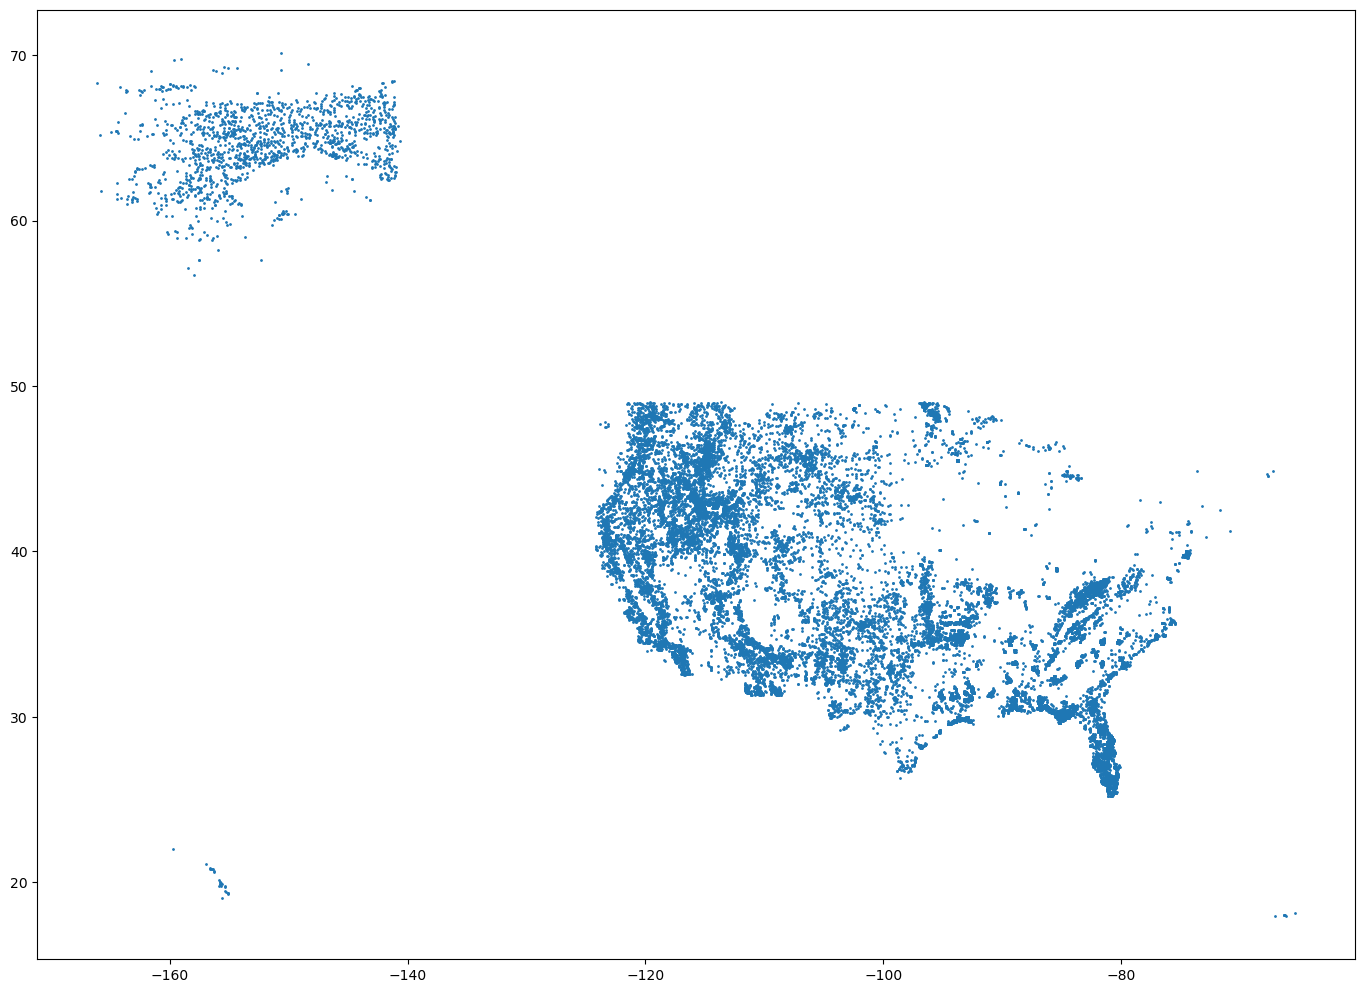

In [283]:
fires.plot(markersize=1,figsize=(17,17))

The goal is to join these two datasets. First make sure they both use the same crs


In [286]:
fires.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [288]:
states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

These two have 2 different projections. We will project the fires shapefile to the states crs 

In [291]:
fires = fires.to_crs({'init':'epsg:4326'})

/opt/anaconda3/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Now we are ready to perform a spatial join, using sjoin method. 

In [303]:
state_fires = gpd.sjoin(fires,states[['name','geometry']].copy(),predicate='within')
state_fires.head()

/var/folders/2x/vymtd9_x51s4l5smfsbyp9m80000gn/T/ipykernel_13332/1343066233.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  state_fires = gpd.sjoin(fires,states[['name','geometry']].copy(),predicate='within')


,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,ORIG_FID,geometry,index_right,name
0,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,-157.421,...,-970,-150,130,334,585,None,0,POINT (-157.42071 62.60301),50,Alaska
1,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,-156.645,...,-970,-150,70,320,600,None,1,POINT (-156.64499 62.56187),50,Alaska
2,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,-153.829,...,-970,-150,50,275,530,None,2,POINT (-153.82867 65.47559),50,Alaska
3,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,-155.265,...,-970,-150,100,321,580,None,3,POINT (-155.26503 65.21013),50,Alaska
4,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,-110.662,...,-970,-150,25,152,320,Hard to delineate fire perimeter,4,POINT (-110.66346 31.77507),6,Arizona


In [307]:
counts_per_state = state_fires.groupby('name').size()
counts_per_state.sort_values(axis=0,ascending=False)

name
Florida           5596
California        1999
Idaho             1627
Texas             1625
Alaska            1479
Arizona           1305
Oregon            1091
New Mexico        1068
Nevada            1043
Mississippi       1023
Montana            908
Alabama            907
South Carolina     856
Louisiana          828
Oklahoma           815
Arkansas           793
Utah               721
Georgia            653
Washington         623
Minnesota          521
Wyoming            457
Colorado           416
Kentucky           386
Kansas             348
Missouri           339
North Carolina     323
West Virginia      313
South Dakota       252
Tennessee          219
Virginia           167
Nebraska           139
New Jersey         115
North Dakota       115
Michigan            83
Indiana             65
Wisconsin           56
Illinois            53
Maryland            41
Hawaii              24
Pennsylvania        18
Iowa                13
New York            11
Ohio                 8
Maine 

These values can be fed to the original shapefile as a new field, showing total wildfire count per state

In [310]:
states = states.merge(counts_per_state.reset_index(name='number_of_fires'))
states.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry,number_of_fires
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,None,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",521
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",908
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,None,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",115
3,Admin-1 scale rank,2,USA-3517,3517,US-HI,http://en.wikipedia.org/wiki/Hawaii,US,8,Hawaii,HI|Hawaii,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080...",24
4,Admin-1 scale rank,2,USA-3518,3518,US-ID,http://en.wikipedia.org/wiki/Idaho,US,1,Idaho,ID|Idaho,...,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -115.9678 47.95...",1627


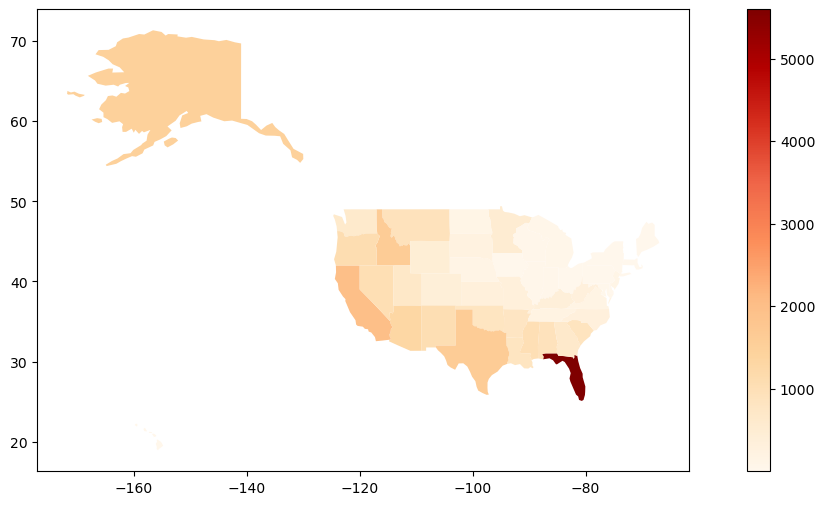

In [314]:
ax = states.plot(column='number_of_fires',figsize=(15,6),cmap='OrRd',legend=True)

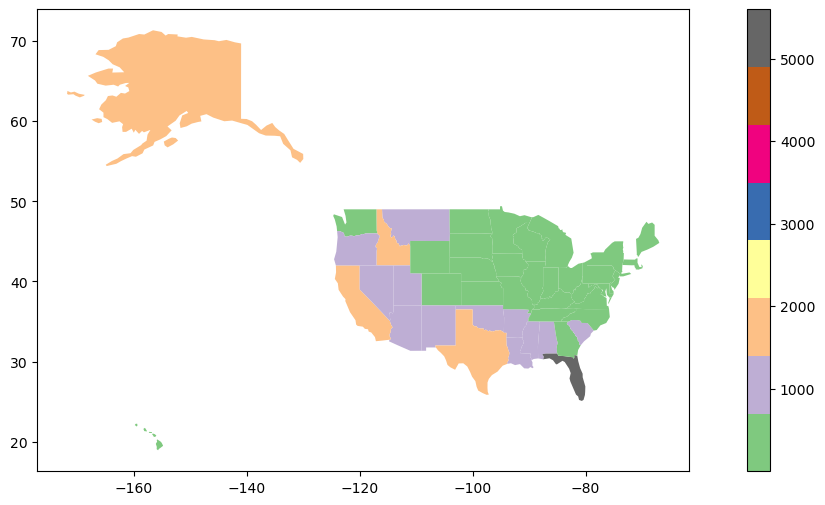

In [319]:
ax = states.plot(column='number_of_fires',figsize=(15,6),cmap='Accent',legend=True)

## Why data inspection matters 
 When preparing data, its good to know the data you are dealing with. Fore example, listing statistics about your dataset that shows you how many elements are there 
,and if there are any missing values. 

In [324]:
len(fires.index)

29583

In [326]:
counts_per_state.sum()

29451

In [328]:
fires.empty

False

## SUMMARY 
This chapter covered 3 python libraries for working with vector data - OGR, Shapely and GeoPandas.